# Gesture Recognition
In this project, we are going to build a model that will be able to predict the 5 gestures correctly.
The training data consists of a few hundred videos categorised into one of the five classes. Each video (typically 2-3 seconds long) is divided into a sequence of 30 frames(images).
The data contains a 'train' and a 'val' folder with two CSV files for the two folders. These folders are in turn divided into subfolders where each subfolder represents a video of a particular gesture. Each subfolder, i.e. a video, contains 30 frames (or images). Note that all images in a particular video subfolder have the same dimensions but different videos may have different dimensions. Specifically, videos have two types of dimensions - either 360x360 or 120x160 (depending on the webcam used to record the videos). Hence, you will need to do some pre-processing to standardise the videos. 

 

Each row of the CSV file represents one video and contains three main pieces of information - the name of the subfolder containing the 30 images of the video, the name of the gesture and the numeric label (between 0-4) of the video.

 

Our task is to train a model on the 'train' folder which performs well on the 'val' folder as well (as usually done in ML projects).
 

To get started with the model building process, you first need to get the data on your storage. 

In order to get the data on the storage, perform the following steps in order

Open the terminal
 g0 down https://drive.google.com/uc?id=1ehyrYBQ5rbQQe6yL4XbLWe3FMvuVUGiL


In [1]:
## Checking the GPU configuration
!nvidia-smi

Sun Apr  9 08:43:31 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import numpy as np
import math
import os
from imageio import imread
from skimage.transform import resize
from skimage.io import imread, imshow
import matplotlib.pyplot as plt
import datetime
import os
import warnings
import cv2
warnings.filterwarnings("ignore")

We set the random seed so that the results don't vary drastically.

In [4]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [5]:
!unzip /content/gdrive/MyDrive/Project_data.zip>/dev/null

**data path: /content/Project_data**

In [6]:
train_doc = np.random.permutation(open('/content/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/content/Project_data/val.csv').readlines())
batch_size = 26

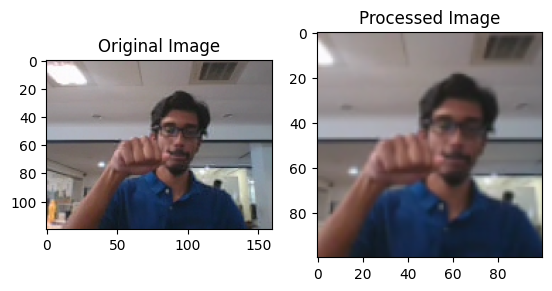

In [7]:
#crop and resize on a single image
def crop_image(image):
    if image.shape[1]==160:
        image=resize(image[:,20:140,:],(84,84)).astype(np.float32)
    else:
        image=resize(image,(84,84)).astype(np.float32)
    return image

image=imread('/content/Project_data/train/WIN_20180926_16_39_19_Pro_Stop_new/WIN_20180926_16_39_19_Pro_00010.png')
# Crop the image
cropped_image = crop_image(image)
# Resize the image
resized_image = resize(cropped_image, (100, 100,3))
# Display the original and processed images
fig, axs = plt.subplots(1, 2)
axs[0].imshow(image)
axs[0].set_title('Original Image')
axs[1].imshow(resized_image)
axs[1].set_title('Processed Image')
plt.show()

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [8]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29]
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t)/batch_size)
        for batch in range(num_batches):
            batch_data = np.zeros((batch_size,18,120,120,3))
            batch_labels = np.zeros((batch_size,5))
            for folder in range(batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    if image.shape[1] == 160:
                        image = resize(image[:,20:140,:],(120,120)).astype(np.float32)
                    else:
                        image = resize(image,(120,120)).astype(np.float32)
                    
                    batch_data[folder,idx,:,:,0] = image[:,:,0] - 104
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - 117
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - 123
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,18,120,120,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    if image.shape[1] == 160:
                        image = resize(image[:,20:140,:],(120,120)).astype(np.float32)
                    else:
                        image = resize(image,(120,120)).astype(np.float32)

                    batch_data[folder,idx,:,:,0] = image[:,:,0] - 104
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - 117
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - 123

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [9]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/Project_data/train'
val_path = '/content/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 30
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 30


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

### 1. Conv3D

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

model = Sequential()
model.add(Conv3D(64, (3,3,3), strides=(1,1,1), padding='same', input_shape=(18,120,120,3)))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2,2,1), strides=(2,2,1)))

model.add(Conv3D(128, (3,3,3), strides=(1,1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

# model.add(Dropout(0.25))

model.add(Conv3D(256, (3,3,3), strides=(1,1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

# model.add(Dropout(0.25))

model.add(Conv3D(256, (3,3,3), strides=(1,1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='elu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [ ]:
sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 18, 120, 120, 64)  5248      
                                                                 
 batch_normalization (BatchN  (None, 18, 120, 120, 64)  256      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 18, 120, 120, 64)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 9, 60, 120, 64)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 9, 60, 120, 128)   221312    
                                                                 
 batch_normalization_1 (Batc  (None, 9, 60, 120, 128) 

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
model_name = 'model_conv3D' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', epsilon=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit` method to decide the number of next() calls it need to make.

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/Project_data/train ; batch size = 26
Epoch 1/30
26/26 [==============================] - ETA: 0s - loss: 3.7778 - categorical_accuracy: 0.3258Source path =  /content/Project_data/val ; batch size = 26

Epoch 1: saving model to model_conv3D_2023-04-0807_43_28.962999/model-00001-3.77777-0.32579-6.35011-0.27000.h5
26/26 [==============================] - 139s 5s/step - loss: 3.7778 - categorical_accuracy: 0.3258 - val_loss: 6.3501 - val_categorical_accuracy: 0.2700 - lr: 0.0010
Epoch 2/30
26/26 [==============================] - ETA: 0s - loss: 1.4670 - categorical_accuracy: 0.5113
Epoch 2: saving model to model_conv3D_2023-04-0807_43_28.962999/model-00002-1.46702-0.51131-6.27074-0.25000.h5
26/26 [==============================] - 123s 5s/step - loss: 1.4670 - categorical_accuracy: 0.5113 - val_loss: 6.2707 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 3/30
26/26 [==============================] - ETA: 0s - loss: 1.2596 - categorical_accuracy: 0.5777
Epoch 

### 2. CNN(VGG16)+RNN(Bidirectional LSTM)

In [ ]:
#model
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Dropout, Flatten, TimeDistributed, Bidirectional, LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.applications.vgg16 import VGG16
    
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(120,120,3),pooling='avg')
x = base_model.output
x = Flatten()(x)
#x.add(Dropout(0.5))
features = Dense(64, activation='relu')(x)
conv_model = Model(inputs=base_model.input, outputs=features)
    
for layer in base_model.layers:
    layer.trainable = False
        
model_sec = Sequential()
model_sec.add(TimeDistributed(conv_model, input_shape=(18,120,120,3)))
model_sec.add(Bidirectional(LSTM(64, return_sequences=True)))
model_sec.add(GRU(32))
model_sec.add(Dropout(0.5))
model_sec.add(Dense(128, activation='relu'))
model_sec.add(Dense(5, activation='softmax'))

In [ ]:
sgd = optimizers.Adam(lr=0.001, decay=1e-6)
model_sec.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_sec.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_2 (TimeDis  (None, 18, 64)           14747520  
 tributed)                                                       
                                                                 
 bidirectional_1 (Bidirectio  (None, 18, 128)          66048     
 nal)                                                            
                                                                 
 gru_3 (GRU)                 (None, 32)                15552     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 128)               4224      
                                                                 
 dense_8 (Dense)             (None, 5)                

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
model_name = 'model_init_conv_lstm' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', epsilon=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [checkpoint, LR]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
model_sec.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/Project_data/train ; batch size = 26
Epoch 1/30
26/26 [==============================] - ETA: 0s - loss: 1.5959 - categorical_accuracy: 0.2549Source path =  /content/Project_data/val ; batch size = 26

Epoch 1: saving model to model_init_conv_lstm_2023-04-0708_27_10.857507/model-00001-1.59589-0.25490-1.50351-0.38000.h5
26/26 [==============================] - 136s 5s/step - loss: 1.5959 - categorical_accuracy: 0.2549 - val_loss: 1.5035 - val_categorical_accuracy: 0.3800 - lr: 0.0010
Epoch 2/30
26/26 [==============================] - ETA: 0s - loss: 1.4070 - categorical_accuracy: 0.4208
Epoch 2: saving model to model_init_conv_lstm_2023-04-0708_27_10.857507/model-00002-1.40699-0.42081-1.26084-0.48000.h5
26/26 [==============================] - 125s 5s/step - loss: 1.4070 - categorical_accuracy: 0.4208 - val_loss: 1.2608 - val_categorical_accuracy: 0.4800 - lr: 0.0010
Epoch 3/30
26/26 [==============================] - ETA: 0s - loss: 1.1341 - categorical_accurac

### 3. CNN(ResNet50)+RNN(Bidirectional GRU)

In [ ]:
#model
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Dropout, Flatten, TimeDistributed, Bidirectional, LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.applications.resnet import ResNet50
    
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(120,120,3),pooling='max')
x = base_model.output
x = Flatten()(x)
features = Dense(128, activation='relu')(x)
conv_model = Model(inputs=base_model.input, outputs=features)
    
for layer in base_model.layers:
    layer.trainable = False
        
model_three = Sequential()
model_three.add(TimeDistributed(conv_model, input_shape=(18,120,120,3)))
model_three.add(Bidirectional(GRU(32, return_sequences=True)))
model_three.add(GRU(16))
model_three.add(Dropout(0.5))
model_three.add(Dense(64, activation='relu'))
model_three.add(Dense(5, activation='softmax'))

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
sgd = optimizers.Adam(lr=0.001, decay=1e-6)
model_three.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_three.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 18, 128)          23849984  
 ibuted)                                                         
                                                                 
 bidirectional (Bidirectiona  (None, 18, 64)           31104     
 l)                                                              
                                                                 
 gru_1 (GRU)                 (None, 16)                3936      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                1088      
                                                                 
 dense_2 (Dense)             (None, 5)                 3

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
model_name = 'model_init_conv_gru' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', epsilon=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [checkpoint, LR]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
model_three.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/Project_data/train ; batch size = 26
Epoch 1/30
26/26 [==============================] - ETA: 0s - loss: 1.5715 - categorical_accuracy: 0.2594Source path =  /content/Project_data/val ; batch size = 26

Epoch 1: saving model to model_init_conv_gru_2023-04-0816_09_56.565715/model-00001-1.57155-0.25943-1.42949-0.50000.h5
26/26 [==============================] - 149s 5s/step - loss: 1.5715 - categorical_accuracy: 0.2594 - val_loss: 1.4295 - val_categorical_accuracy: 0.5000 - lr: 0.0010
Epoch 2/30
26/26 [==============================] - ETA: 0s - loss: 1.4327 - categorical_accuracy: 0.3680
Epoch 2: saving model to model_init_conv_gru_2023-04-0816_09_56.565715/model-00002-1.43267-0.36802-1.29502-0.47000.h5
26/26 [==============================] - 120s 5s/step - loss: 1.4327 - categorical_accuracy: 0.3680 - val_loss: 1.2950 - val_categorical_accuracy: 0.4700 - lr: 0.0010
Epoch 3/30
26/26 [==============================] - ETA: 0s - loss: 1.3026 - categorical_accuracy:

### Choosing model_three(CNN+RNN) as final model.

## Prediction

In [16]:
#assigning model_three as final model and predicting on a single sequence
from tensorflow.keras.models import load_model
from google.colab import files  
final_model = load_model('CNN_RNN_FINAL.h5')

In [20]:
#preprocessing single video sequence to make prediction upon
img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29]
video=[]
imgs = os.listdir('/content/Project_data/train/WIN_20180907_15_38_35_Pro_Thumbs Down_new'.split(';')[0])
for idx,item in enumerate(img_idx):
  image = imread('/content/Project_data/train/WIN_20180907_15_38_35_Pro_Thumbs Down_new'.strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
  if image.shape[1] == 160:
    image = resize(image[:,20:140,:],(120,120)).astype(np.float32)
  else:
    image = resize(image,(120,120)).astype(np.float32)
  image[:,:,0] -= 104
  image[:,:,1] -= 117
  image[:,:,2] -= 123
  video.append(image)                 
video = np.expand_dims(np.array(video), axis=0)
video.shape

(1, 18, 120, 120, 3)

In [21]:
final_model.predict(video)

1/1 [==============================] - 0s 30ms/step


array([[1.6398988e-04, 1.0931127e-04, 2.5824511e-03, 8.9063227e-01,
        1.0651199e-01]], dtype=float32)

model predicting thumbs down gesture video as thumbs down(category:3)